In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report,roc_curve, auc, plot_roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.utils import resample
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 
from collections import Counter

pred_path = "../files/SeizurePrediction/"
dect_path = "../files/SeizureDetection/"

In [2]:
def balance_data(data_x, data_y,verbose=False):
    if verbose: print('Original dataset shape %s' % Counter(data_y))
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(data_x, data_y)
    if verbose: print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

def scale_data(x):
    train_scaler = preprocessing.StandardScaler().fit(x)
    return train_scaler.transform(x)

def print_statistics(y_test, y_pred,i=None):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    PPV = tp / (tp+fp)
    f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))
    print("{:^5d},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f}".format(i,specificity,sensitivity,accuracy,PPV,f1))

def train_pred(X, y, save=False, dop=""):
    cv = StratifiedKFold(5,shuffle = False)
    tprs = []
    aucs = []
    
    originalclass = []
    predictedclass = []

    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(8,6))
    print("{:^5s},{:^15s},{:^15s},{:^15s},{:^15s},{:^15s}".format("fold","specificity","sensitivity",'accuracy','PPV','f1'))
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train, y_train = balance_data(X[train], y[train])
        print(X_train[range(5),range(5)])
        scaler = preprocessing.StandardScaler().fit(X[train])
        X_train = scaler.transform(X_train)
        X_test, y_test = X[test], y[test]
        X_test = scaler.transform(X_test)
        class_model = GradientBoostingClassifier(n_estimators=200,max_features='sqrt',random_state=2021).fit(X_train, y_train)
#         y_pred = class_model.predict(X_test)
                
        y_hat = class_model.predict_proba(X_test)[:, 1]
        # Calculate the ROC Curves
        fpr, tpr, thresholds = roc_curve(y_test, y_hat)
        gmeans = np.sqrt(tpr * (1-fpr))
        
        ix = np.argmax(gmeans)
        y_pred = class_model.predict_proba(X_test)[:,1] >= thresholds[ix]
        ax.scatter(fpr[ix], tpr[ix], marker='o', color='red', alpha=0.3)
        originalclass.extend(y_test)
        predictedclass.extend(y_pred)
        
        viz = plot_roc_curve(class_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        # basic statistics
        print_statistics(y_test, y_pred,i)
        print_statistics(y_test, class_model.predict(X_test),i)
        
    print(classification_report(originalclass, predictedclass))
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.legend(loc="lower right")
    if save:
        plt.savefig(os.path.join("./figures", "gbdt_noshuffle_{}_{}.pdf".format(dop,save)))
    plt.show()
    return aucs


========== Dog_1_reduced ==========
[   31.38554  -428.0891     17.9564  -1303.395      19.84129]
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
[   15.67629 -1096.402      19.09728  -154.7724     18.33961]
  0  ,    0.4375     ,    0.6538     ,    0.4480     ,    0.0557     ,    0.1027     
  0  ,    0.9609     ,    0.0000     ,    0.9145     ,    0.0000     ,      nan      
[   31.38554  -428.0891     17.9564  -1303.395      19.84129]


<ipython-input-2-831726933d54>:18: RuntimeWarning: invalid value encountered in double_scalars
  f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))


  1  ,    0.5371     ,    0.4615     ,    0.5335     ,    0.0482     ,    0.0873     
  1  ,    0.9023     ,    0.0000     ,    0.8587     ,    0.0000     ,      nan      
[   31.38554  -428.0891     17.9564  -1303.395      19.84129]


<ipython-input-2-831726933d54>:18: RuntimeWarning: invalid value encountered in double_scalars
  f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))


  2  ,    0.7129     ,    0.7308     ,    0.7138     ,    0.1145     ,    0.1979     
  2  ,    0.9395     ,    0.3077     ,    0.9089     ,    0.2051     ,    0.2462     
[   31.38554  -428.0891     17.9564  -1303.395      19.84129]
  3  ,    0.6211     ,    0.6400     ,    0.6220     ,    0.0762     ,    0.1362     
  3  ,    0.9199     ,    0.2000     ,    0.8864     ,    0.1087     ,    0.1408     
[   31.38554  -428.0891     17.9564  -1303.395      19.84129]
  4  ,    0.6797     ,    0.6000     ,    0.6760     ,    0.0838     ,    0.1471     
  4  ,    0.9297     ,    0.1600     ,    0.8939     ,    0.1000     ,    0.1231     
              precision    recall  f1-score   support

         0.0       0.97      0.60      0.74      2560
         1.0       0.07      0.62      0.13       128

    accuracy                           0.60      2688
   macro avg       0.52      0.61      0.43      2688
weighted avg       0.93      0.60      0.71      2688



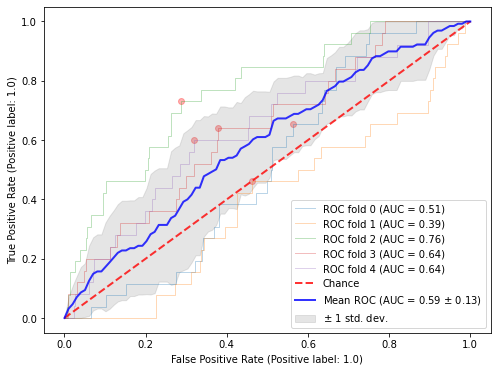

[0.5142728365384616, 0.3934044471153846, 0.7623948317307692, 0.6375, 0.6374218749999999]
0.588998798076923
========== Dog_2_reduced ==========
[1736.04119811   23.28086513 1162.43056624   20.97122559 -594.67257696]
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
[ 820.22480135   16.95077311  358.15699717   15.76132846 -753.04963377]
  0  ,    0.7865     ,    0.7273     ,    0.7820     ,    0.2192     ,    0.3368     
  0  ,    0.9101     ,    0.3864     ,    0.8702     ,    0.2615     ,    0.3119     
[1736.04119811   23.28086513 1162.43056624   20.97122559 -594.67257696]
  1  ,    0.8161     ,    0.8889     ,    0.8218     ,    0.2899     ,    0.4372     
  1  ,    0.9231     ,    0.5778     ,    0.8962     ,    0.3881     ,    0.4643     
[1736.04119811   23.28086513 1162.43056624   20.97122559 -594.67257696]
  2  ,    0.7674     ,    0.8444     ,    0.7734     ,    0.2346     ,    0.3671     
  2  ,    0.9512     ,    0.1778     ,    0.8910     

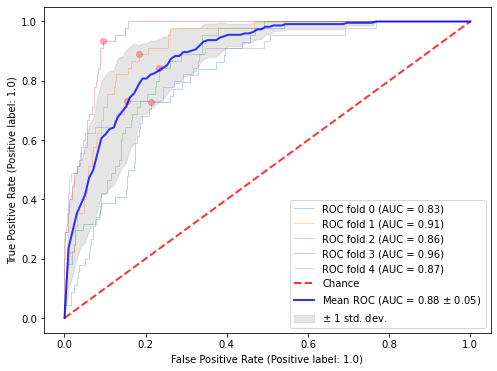

[0.8281835205992509, 0.9142797581821972, 0.855409631019387, 0.9586408171774026, 0.8709193245778611]
0.8854866103112198
========== Dog_3_reduced ==========
[  18.49384    29.66389  1566.953      39.46827     3.191291]
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
[28.79308  42.3432   94.82147  42.31448   6.716692]
  0  ,    0.6908     ,    0.8052     ,    0.6962     ,    0.1155     ,    0.2020     
  0  ,    0.9896     ,    0.0779     ,    0.9461     ,    0.2727     ,    0.1212     
[  18.49384    29.66389  1566.953      39.46827     3.191291]
  1  ,    0.8385     ,    0.7403     ,    0.8338     ,    0.1869     ,    0.2984     
  1  ,    0.9922     ,    0.4675     ,    0.9671     ,    0.7500     ,    0.5760     
[  18.49384    29.66389  1566.953      39.46827     3.191291]
  2  ,    0.9622     ,    0.9610     ,    0.9622     ,    0.5606     ,    0.7081     
  2  ,    0.9583     ,    0.9610     ,    0.9585     ,    0.5362     ,    0.6884     
[  18

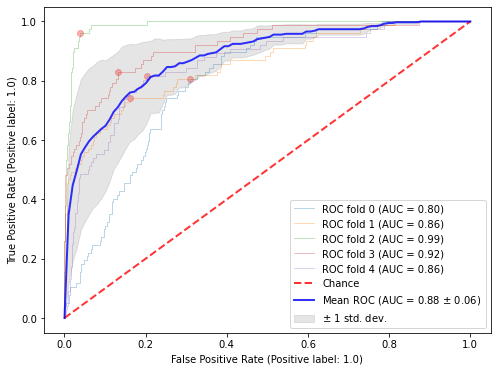

[0.7969680059523809, 0.8550375405844156, 0.9877908549783551, 0.9175037202380952, 0.8575332373903509]
0.8829666718287197
========== Dog_4_reduced ==========
[  6.461733 118.3472   105.3744   119.6074     7.091007]
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
[   4.99729  2220.505      85.20336    83.17807     5.994639]
  0  ,    0.3217     ,    0.5192     ,    0.3430     ,    0.0849     ,    0.1459     
  0  ,    0.8462     ,    0.0769     ,    0.7630     ,    0.0571     ,    0.0656     
[  6.461733 118.3472   105.3744   119.6074     7.091007]
  1  ,    0.6841     ,    0.7692     ,    0.6933     ,    0.2279     ,    0.3516     
  1  ,    0.8193     ,    0.3365     ,    0.7672     ,    0.1842     ,    0.2381     
[  6.461733 118.3472   105.3744   119.6074     7.091007]
  2  ,    0.6841     ,    0.5865     ,    0.6736     ,    0.1837     ,    0.2798     
  2  ,    0.8765     ,    0.3269     ,    0.8170     ,    0.2429     ,    0.2787     
[  6.4617

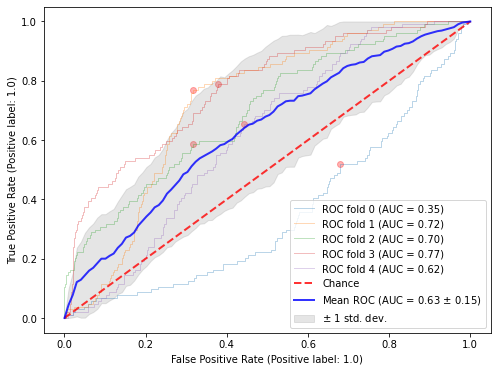

[0.34965034965034963, 0.7225098619329389, 0.6965998744844898, 0.7736289381563594, 0.6152387577416749]
0.6315255563931624
========== Dog_5_reduced ==========
[  19.84988012   39.10566301 4084.34499615   48.02581732    4.55780831]
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
[ 20.10024551  21.43833037 815.52102356  20.79644166   3.32965978]
  0  ,    0.8938     ,    0.9688     ,    0.8984     ,    0.3780     ,    0.5439     
  0  ,    0.9396     ,    0.5312     ,    0.9141     ,    0.3696     ,    0.4359     
[  19.84988012   39.10566301 4084.34499615   48.02581732    4.55780831]
  1  ,    0.9396     ,    1.0000     ,    0.9434     ,    0.5246     ,    0.6882     
  1  ,    0.9979     ,    0.7812     ,    0.9844     ,    0.9615     ,    0.8621     
[  19.84988012   39.10566301 4084.34499615   48.02581732    4.55780831]
  2  ,    0.9396     ,    0.8125     ,    0.9316     ,    0.4727     ,    0.5977     
  2  ,    0.9875     ,    0.5938     ,    0.

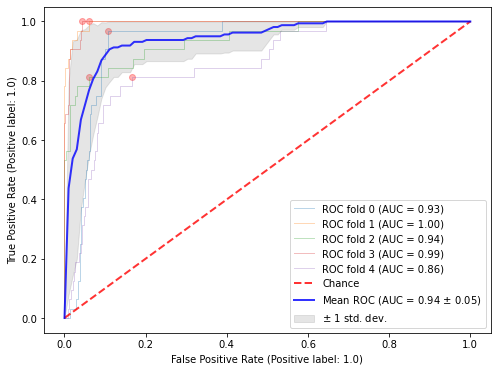

[0.9317708333333334, 0.9957682291666666, 0.939453125, 0.9938151041666667, 0.85625]
0.9434114583333335
========== Patient_1_reduced ==========
[ 2.91552995  3.14155456 34.79409307 43.49544116 44.70195176]
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
[ 2.74116614  2.99846726 66.89054272 96.16635438 83.05660299]
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    0.8000     ,    1.0000     ,    0.8533     ,    0.6452     ,    0.7843     
[ 2.91552995  3.14155456 34.79409307 43.49544116 44.70195176]
  1  ,    0.8000     ,    1.0000     ,    0.8533     ,    0.6452     ,    0.7843     
  1  ,    0.8909     ,    0.8000     ,    0.8667     ,    0.7273     ,    0.7619     
[ 2.91552995  3.14155456 34.79409307 43.49544116 44.70195176]
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
[ 2.9155

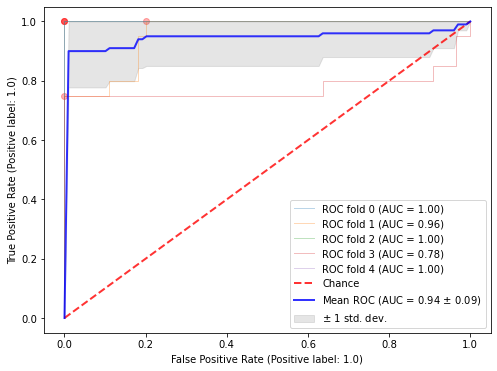

[1.0, 0.9572727272727273, 1.0, 0.7763636363636364, 1.0]
0.9467272727272726
========== Patient_2_reduced ==========
[  5.79951201   6.48939183  81.78026605 104.91523621 106.65775377]
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
[  6.33386874   5.69472256  82.83041832 105.06875126 108.96067123]
  0  ,    0.9574     ,    1.0000     ,    0.9697     ,    0.9048     ,    0.9500     
  0  ,    0.9574     ,    1.0000     ,    0.9697     ,    0.9048     ,    0.9500     
[  5.79951201   6.48939183  81.78026605 104.91523621 106.65775377]
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
[  5.79951201   6.48939183  81.78026605 104.91523621 106.65775377]
  2  ,    0.2609     ,    1.0000     ,    0.4848     ,    0.3704     ,    0.5405     
  2  ,    0.2826     ,    0.4500     ,    0.3333     ,    0.2143     ,    0.2903     
[  5.79951201  

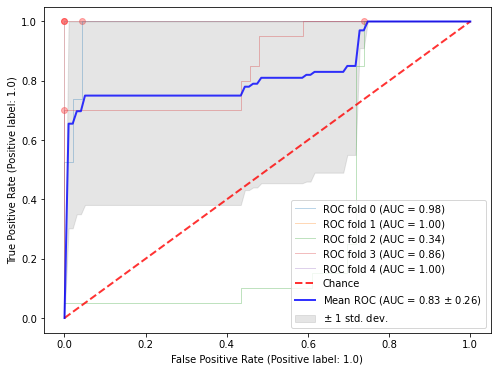

[0.9843225083986562, 1.0, 0.3369565217391305, 0.8565217391304347, 1.0]
0.8355601538536442


In [4]:
file_list = [f for f in Path(pred_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    print('='*10, sample ,'='*10)
    data_y = data["result"].to_numpy()
    data_x = data.loc[:, data.columns != 'result'].to_numpy()
    print(data_x[range(5),range(5)])
    aucs = train_pred(data_x, data_y,save=sample,dop="pred")
    print(aucs)
    print(np.mean(aucs))